# Unit testing mathematical code

In [1]:
import numpy as np
import tueplots.constants.color.rgb as rgb
from matplotlib import pyplot as plt
from matplotlib import ticker
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

Let's say (to pick a very simple example) that you want to implement **Principal Componentn Analysis (PCA)**. Let's load a dataset first.

In [2]:
# the labeled faces in the wild dataset
N = 13232
dim = (49, 36)
D = 49 * 36

X = np.array(
    [
        np.loadtxt(f"../../04_notebooks/Fair-PCA/data/images/img{i}.txt").ravel()
        for i in range(N)
    ]
)

print(X.shape)

(13232, 1764)


So let's say you read somewhere that PCA works by computing the **right singular vectors** of $X$, and that those are the same as **the eigenvectors of the covariance matrix**. So you implement that:

In [3]:
Q, lam, U_t = np.linalg.svd(X)
U = U_t.T
C = np.cov(X, rowvar=False)

It's easy to write a classic unit test:

In [7]:
assert U_t.shape == C.shape

But that doesn't help us at all. It just checks that the datatypes (here: matrix shapes) are the same. Not that they have the mathematical properties we're looking for. Instead, let's do a visual test: The matrix

$$ \operatorname{diag}(\lambda^{-1}) U C U^T $$

Should be the unit matrix, right?

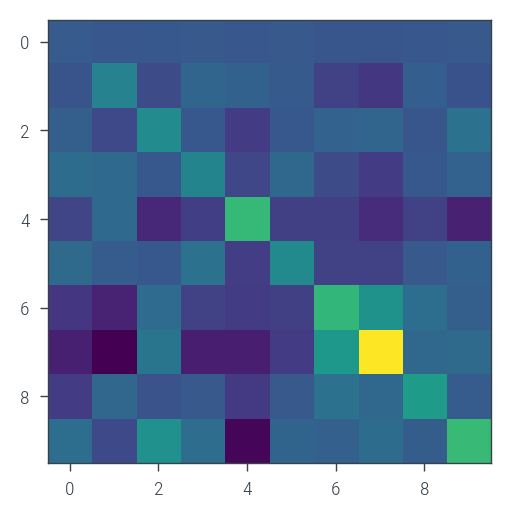

In [9]:
D = np.diag(1.0 / lam) @ U @ C @ U.T  # <- should be a unit matrix

plt.imshow(D[:10, :10]);

Ah, we got the transpose wrong!

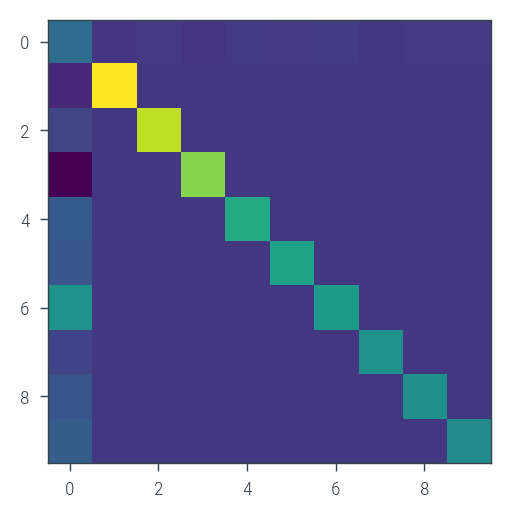

In [10]:
D = np.diag(1.0 / lam) @ U.T @ C @ U  # <- should be a unit matrix
plt.imshow(D[:10, :10]);

That looks better. But what is this weird column on the left? Ah! We forgot to center first! The covariance matrix is given by 

$$ C = \frac{1}{N} \sum_i (x_i - \bar{x})(x_i - \bar{x})^T = \frac{1}{N} (X- 1^TX 1^T)^T (X- 1^TX 1^T)$$

But the SVD directly operates on $X$ to compute $X = Q\Sigma U^T$

In [11]:
mX = np.mean(X, axis=0)
X -= mX
Q, lam, U_t = np.linalg.svd(X)
U = U_t.T

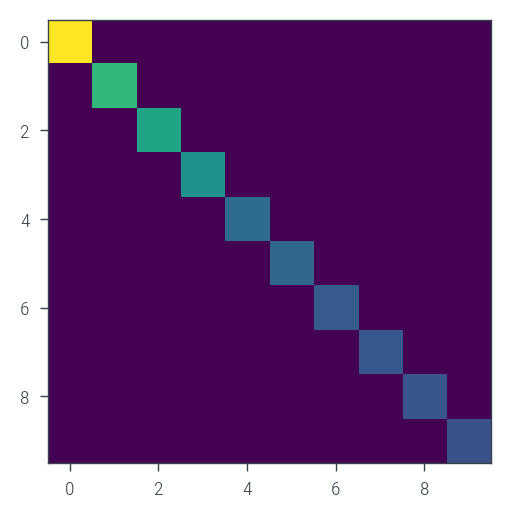

In [12]:
D = np.diag(1.0 / lam) @ U.T @ C @ U  # <- should be a unit matrix
plt.imshow(D[:10, :10]);

Nice! Now we have our diagonal matrix...

Hm. Hang on. Didnt we say this should be a *unit* matrix? 

Ah! The SVD produces singular vectors. The Eigenvectors of $C$ are those of 
$$X^TX = U\Sigma Q^T Q \Sigma U^T = U \Sigma^2 U^T$$
So the eigenvalues of $C$ are the *squares* of the singular values:

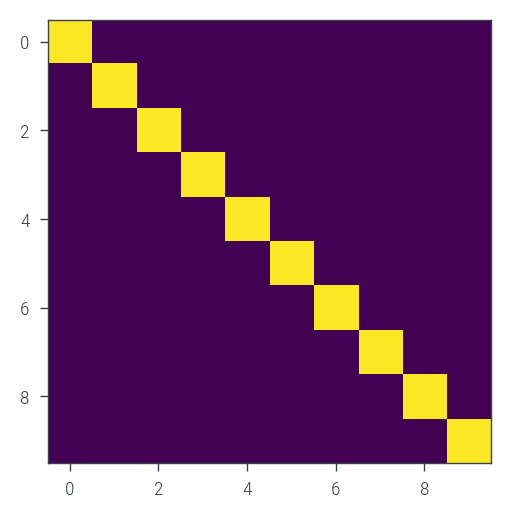

In [14]:
D = np.diag(1.0 / lam ** 2) @ U.T @ C @ U  # <- should be a unit matrix
plt.imshow(D[:10, :10]);

Tadaa! We're done! Just to be sure, let's check the scale:

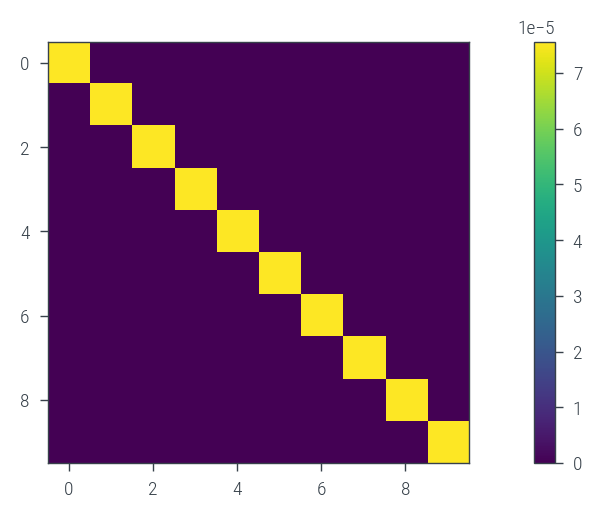

In [15]:
D = np.diag(1.0 / lam ** 2) @ U.T @ C @ U  # <- should be a unit matrix
plt.imshow(D[:10, :10])
plt.colorbar();

Huh?

Ah! We forgot to divide by $N$! Remember that 

$$ C = \frac{1}{N} \sum_i (x_i - \bar{x})(x_i - \bar{x})^T = \frac{1}{N} (X- 1^TX 1^T)^T (X- 1^TX 1^T)$$

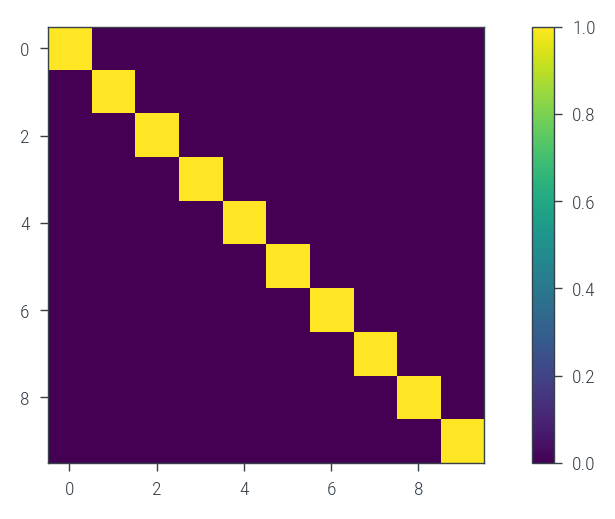

In [16]:
D = N * (np.diag(1.0 / lam ** 2) @ U.T @ C @ U)  # <- should be a unit matrix
plt.imshow(D[:10, :10])
plt.colorbar();

Nice! Looks we're done here. Let's just check numerically:

In [17]:
print(f"the first few diagonal entries are {np.diag(D)[:10]}")

the first few diagonal entries are [1.00007558 1.00007558 1.00007558 1.00007558 1.00007558 1.00007558
 1.00007558 1.00007558 1.00007558 1.00007558]


Dammit!

`numpy` uses the unbiased covariance estimate!

the first few diagonal entries are [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


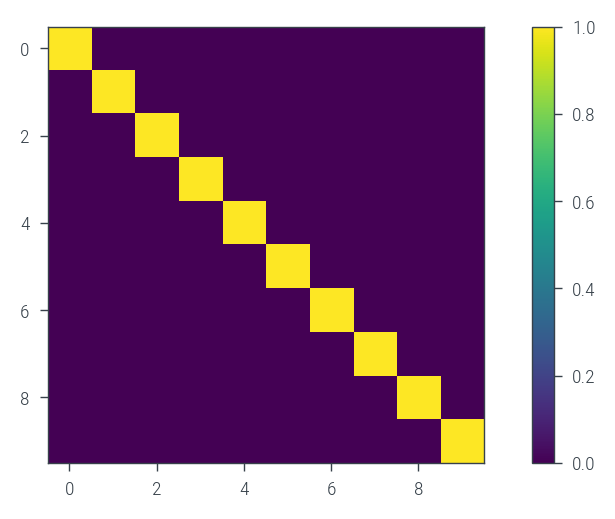

In [18]:
D = (N - 1) * (np.diag(1.0 / lam ** 2) @ U.T @ C @ U)  # <- should be a unit matrix
plt.imshow(D[:10, :10])
plt.colorbar()
print(f"the first few diagonal entries are {np.diag(D)[:10]}")

*Now* we got it. To be totally sure, let's look at those eigenvectors.

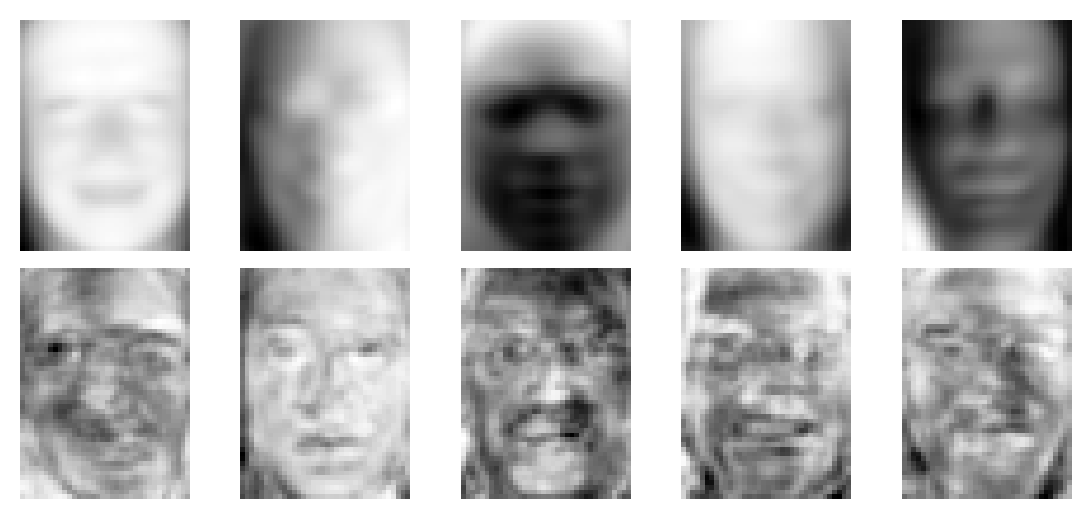

In [19]:
m, d = X.shape
dim = (49, 36)

fig, ax = plt.subplots(2, 5)
for i in range(5):
    # let's look at the first 5 singular vectors
    ax[0, i].imshow(U[:, i].reshape(dim), cmap="Greys_r")
    ax[0, i].axis("off")

    # and we generate a few "shallow VAE samples" ;)
    z = np.random.randn(d, 1)
    f = U @ np.diag(lam) @ z
    ax[1, i].imshow(f.reshape(dim), cmap="Greys_r")
    ax[1, i].axis("off")